# Preliminary Study

## global imports

In [91]:
import os
import pandas as pd
import re
import json

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm.notebook import tqdm

EO_DATE = '2025_01_20'


In [92]:
before = pd.read_csv('data/before.csv')
before['locality'] = before['location'].str.split(', ').str[0]
before['region'] = before['location'].str.split(', ').str[1]
before.drop(columns=['location'], inplace=True)
display(before.head())

print(before['description'].iloc[0])

after = pd.read_csv('data/after.csv', index_col=0)
display(after.head())

,title,publishedAt,companyName,description,applicationsCount,contractType,experienceLevel,workType,sector,locality,region
0,AI/ML Engineer,2024-05-29,Wesper,THE OPPORTUNITY\n\nWesper is looking for a sma...,Over 200 applicants,Full-time,Mid-Senior level,Engineering and Information Technology,Internet Publishing,New York,NY
1,Software Engineer - AI/ML Systems,NaN,Snorkel AI,We're on a mission to democratize AI by buildi...,51 applicants,Full-time,Entry level,Engineering and Information Technology,Software Development,Redwood City,CA
2,ML Engineer at 100% Remote,2024-06-01,ELITE MENTE LLC,"Hello ,\n\nHope you are doing well!\n\nPlease ...",Be among the first 25 applicants,Full-time,Entry level,Engineering and Information Technology,Staffing and Recruiting,San Jose,CA
3,Machine Learning Engineer (L4) - Infrastructur...,2024-05-19,Netflix,At Netflix our goal is to entertain the world....,Over 200 applicants,Full-time,Not Applicable,Engineering and Information Technology,"Entertainment Providers, Technology, Informati...",Los Gatos,CA
4,Data Scientist / ML Engineer,NaN,"Paradyme, Inc.",Overview\n\nParadyme Management is a rapidly g...,110 applicants,Full-time,Entry level,Engineering and Information Technology,IT Services and IT Consulting,Redwood City,CA


THE OPPORTUNITY

Wesper is looking for a smart and creative engineer to lead our AI/ML efforts and product initiatives. This includes advanced ML modeling for large-scale healthcare data synthesis, deep physiological signal optimization pipelines, and generative AI architectures. The right candidate will have an opportunity to research, design and implement novel solutions alongside the software team, and serve as a subject matter expert on all artificial intelligence matters for the company.

Reports into VP R&D.

Responsibilities


 * Work with CTO, VP R&D, and software leadership to shape and commercialize Wesper’s AI/ML strategy
 * Design and implement feature engineering and ML models for both physiological-level and population-level processing of large-scale clinical sleep data for predictive automation
 * Participate in Wesper’s discovery and evolution efforts into generative AI
 * Assist with ongoing post-market maintenance of AI/ML applications, including defect resolution and

,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title
0,2024-10-31,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,Internship - Machine Learning Engineer & Data ...
1,2025-03-14,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,Machine Learning Engineer
2,2025-04-09,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,Machine Learning Engineer
3,2025-03-22,Mountain View,California,Waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"Machine Learning Engineer, Training"
4,2025-03-28,Boston,Massachusetts,HMH,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,Machine Learning Engineer


In [93]:
pd.to_datetime(before['publishedAt']).dt.to_period('M').value_counts().sort_index()

publishedAt
2022-03      1
2022-09      1
2022-10      1
2023-02      1
2023-03      5
2023-04      2
2023-05      1
2023-06     10
2023-07      3
2023-08      2
2023-09      4
2023-10      4
2023-11      5
2023-12     13
2024-01     15
2024-02     35
2024-03     49
2024-04    134
2024-05    543
2024-06     21
Freq: M, Name: count, dtype: int64

In [94]:
if os.path.exists('data/merged.csv'):
    merged = pd.read_csv('data/merged.csv')
else:
    # merge datasets on common columns
    rename_map_before = {
        'title': 'job_title',
        'locality': 'company_address_locality',
        'region': 'company_address_region',
        'publishedAt': 'job_posted_date',
        'companyName': 'company_name',
        'description': 'job_description_text',
        'experienceLevel': 'seniority_level',
        'applicationsCount': 'num_applications',
        'contractType': 'contract_type',
        'workType': 'work_type'
    }

    before = before.rename(columns=rename_map_before)

    common_columns = [col for col in before.columns if col in after.columns]

    merged = pd.concat([before, after], ignore_index=True)
    display(merged.head())

    # save merged dataset
    merged.dropna(inplace=True, subset=['job_description_text', 'job_posted_date'], how='any')
    merged.to_csv('data/merged.csv', index=False)
display(merged.head())

,job_title,job_posted_date,company_name,job_description_text,num_applications,contract_type,seniority_level,work_type,sector,company_address_locality,company_address_region,company_website,company_description
0,AI/ML Engineer,2024-05-29,Wesper,THE OPPORTUNITY\n\nWesper is looking for a sma...,Over 200 applicants,Full-time,Mid-Senior level,Engineering and Information Technology,Internet Publishing,New York,NY,NaN,NaN
1,ML Engineer at 100% Remote,2024-06-01,ELITE MENTE LLC,"Hello ,\n\nHope you are doing well!\n\nPlease ...",Be among the first 25 applicants,Full-time,Entry level,Engineering and Information Technology,Staffing and Recruiting,San Jose,CA,NaN,NaN
2,Machine Learning Engineer (L4) - Infrastructur...,2024-05-19,Netflix,At Netflix our goal is to entertain the world....,Over 200 applicants,Full-time,Not Applicable,Engineering and Information Technology,"Entertainment Providers, Technology, Informati...",Los Gatos,CA,NaN,NaN
3,ML Engineer-AI/ML,2024-04-30,Zortech Solutions,"Role: ML Engineer-AI/ML\n\nLocation: Austin, T...",67 applicants,Full-time,Entry level,Engineering and Information Technology,Human Resources Services,Austin,TX,NaN,NaN
4,ML/ Machine Learning/ Data Scientist/ AI/ Arti...,2024-05-20,HatchPros,"T+S\n\nUSC/GC\n\nNeed VISA, DL and LinkedIn\n\...",145 applicants,Contract,Mid-Senior level,Engineering and Information Technology,IT Services and IT Consulting,Richardson,TX,NaN,NaN


In [ ]:
# regularize job description text
def regularize_text(text):
    if pd.isna(text):
        return ''
    text = text.lower() # lowercase
    text = re.sub(r'[^a-z\d\s\.]', ' ', text) # remove non-alphanumeric characters except periods (e.g.for degrees)
    text = re.sub(r'\.(\s|$)', ' ', text) # replace ending periods with spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
merged['description_reg'] = merged['job_description_text'].apply(regularize_text)
print(merged['description_reg'].iloc[80])

about ascendion ascendion is a full service digital engineering solutions company we make and manage software platforms and products that power growth and deliver captivating experiences to consumers and employees our engineering cloud data experience design and talent solution capabilities accelerate transformation and impact for enterprise clients headquartered in new jersey our workforce of 6 000 ascenders delivers solutions from around the globe ascendion is built differently to engineer the next ascendion engineering to elevate life we have a culture built on opportunity inclusion and a spirit of partnership come change the world with us build the coolest tech for world s leading brands solve complex problems and learn new skill experience the power of transforming digital engineering for fortune 500 clients master your craft with leading training programs and hands on experience experience a community of change makers join a culture of high performing innovators with endless idea

## eda

In [96]:
# summary statistics
before_all = before.shape[0]
before_distinct = before.nunique()
before_missing = before.isnull().sum()
before_sum = pd.DataFrame({'total_rows': before_all, 'distinct_values': before_distinct, 'missing_values': before_missing})
display(before_sum)

after_all = after.shape[0]
after_distinct = after.nunique()
after_missing = after.isnull().sum().T
after_sum = pd.DataFrame({'total_rows': after_all, 'distinct_values': after_distinct, 'missing_values': after_missing})
display(after_sum)


,total_rows,distinct_values,missing_values
title,862,450,0
publishedAt,862,142,12
companyName,862,519,1
description,862,748,0
applicationsCount,862,145,0
contractType,862,5,0
experienceLevel,862,7,0
workType,862,55,0
sector,862,156,3
locality,862,159,0


,total_rows,distinct_values,missing_values
job_posted_date,997,116,0
company_address_locality,997,178,47
company_address_region,997,87,113
company_name,997,488,0
company_website,997,478,14
company_description,997,480,12
job_description_text,997,795,1
seniority_level,997,7,9
job_title,997,450,0


<Figure size 1200x600 with 0 Axes>

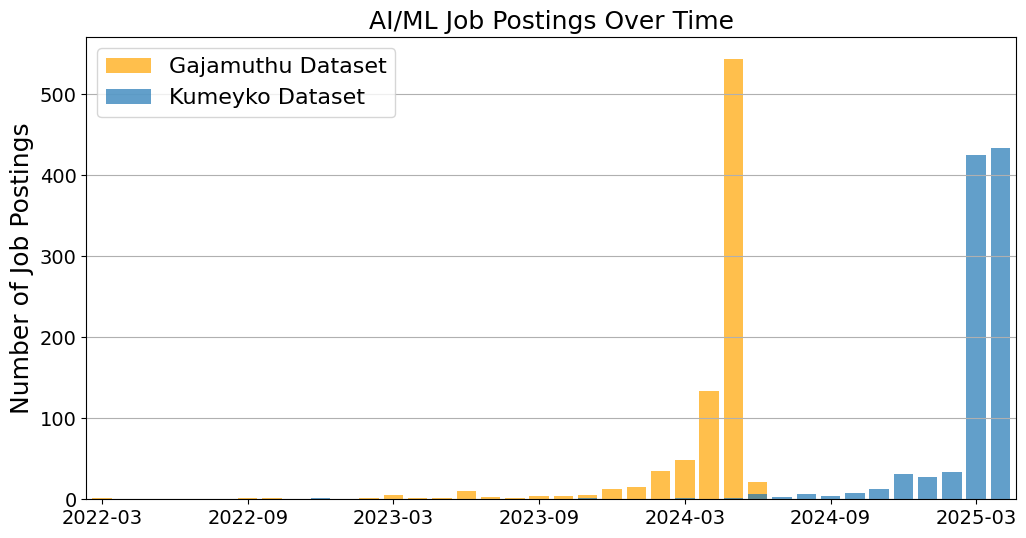

In [97]:
# total number of job postings over time, combining both datasets into one
plt.figure(figsize=(12, 6))
before['date'] = pd.to_datetime(before['publishedAt'])
after['date'] = pd.to_datetime(after['job_posted_date'])
merged['date'] = pd.to_datetime(merged['job_posted_date'])

before_counts = before['date'].dropna().dt.to_period('M').value_counts().sort_index()
after_counts = after['date'].dropna().dt.to_period('M').value_counts().sort_index()

min_date = min(before['date'].min(), after['date'].min())
max_date = max(before['date'].max(), after['date'].max())
# Generate ALL months in the range
all_months = pd.period_range(
    start=pd.Period(min_date, freq='M'),
    end=pd.Period(max_date, freq='M'),
    freq='M'
)

before_counts = before_counts.reindex(all_months, fill_value=0)
after_counts = after_counts.reindex(all_months, fill_value=0)

# combine the two series by date
# total_counts = before_counts.add(after_counts, fill_value=0)
# total_counts = total_counts.sort_index()
# plt.plot(total_counts.index, total_counts.values, marker='o', label='Total Job Postings')
# plt.bar(before_counts.index, before_counts.values, label='Gajamuthu Dataset')
# plt.bar(after_counts.index, after_counts.values, label='Kumeyko Dataset')
fig, ax = plt.subplots(figsize=(12, 6))
before_counts.plot(kind='bar', label='Gajamuthu Dataset', color='orange', alpha=0.7, ax=ax, width=0.8)
after_counts.plot(kind='bar', label='Kumeyko Dataset', alpha=0.7, ax=ax, width=0.8)
# set x axis range to be the union of both datasets
# ax.set_xlim(min(before_counts.index.min(), after_counts.index.min()), max(before_counts.index.max(), after_counts.index.max()))
plt.legend(fontsize=16)
plt.title('AI/ML Job Postings Over Time', fontsize=18)
# plt.xlabel('Date')
x_labels = all_months.astype(str)
ax.set_xticks(np.arange(len(x_labels), step=6)) 
ax.set_xticklabels(x_labels[::6], rotation=0, ha='center', fontsize=14)
plt.ylabel('Number of Job Postings', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
plt.grid(axis='y')
plt.show()

## word processing

In [98]:
# put job descriptions into a single list for word processing
descriptions = merged['description_reg'].dropna().str.split().tolist()
print(f'Total number of job descriptions: {len(descriptions)}')
print(descriptions[0])

Total number of job descriptions: 1846
['the', 'opportunity', 'wesper', 'is', 'looking', 'for', 'a', 'smart', 'and', 'creative', 'engineer', 'to', 'lead', 'our', 'ai', 'ml', 'efforts', 'and', 'product', 'initiatives', 'this', 'includes', 'advanced', 'ml', 'modeling', 'for', 'large', 'scale', 'healthcare', 'data', 'synthesis', 'deep', 'physiological', 'signal', 'optimization', 'pipelines', 'and', 'generative', 'ai', 'architectures', 'the', 'right', 'candidate', 'will', 'have', 'an', 'opportunity', 'to', 'research', 'design', 'and', 'implement', 'novel', 'solutions', 'alongside', 'the', 'software', 'team', 'and', 'serve', 'as', 'a', 'subject', 'matter', 'expert', 'on', 'all', 'artificial', 'intelligence', 'matters', 'for', 'the', 'company', 'reports', 'into', 'vp', 'r', 'd', 'responsibilities', 'work', 'with', 'cto', 'vp', 'r', 'd', 'and', 'software', 'leadership', 'to', 'shape', 'and', 'commercialize', 'wesper', 's', 'ai', 'ml', 'strategy', 'design', 'and', 'implement', 'feature', 'engi

In [99]:
if os.path.exists("data/dei_terms.json"):
    with open('data/dei_terms.json', 'r') as f:
        dei = json.load(f)
        dei_narrow = dei['narrow']
        dei_expanded = dei['expanded']
    print(f"Loaded DEI terms from file: {dei}")

else:
    dei_narrow = ["diversity", "diverse", "equity", "equitable", "inclusion", "inclusive"]

    # get the 20 most similar words by word2vec for each of the DEI_NARROW terms
    from gensim.models import Word2Vec
    if not os.path.exists("word2vec.model"):
        model = Word2Vec(sentences=descriptions, vector_size=100, window=5, min_count=1, workers=4)
        model.save("word2vec.model")

    model = Word2Vec.load("word2vec.model")
    dei_expanded = set(dei_narrow)
    # similarities = {}
    for term in dei_narrow:
        if term in model.wv:
            # similarities[term] = {}
            similar_words = model.wv.most_similar(term, topn=30)
            for word, similarity in similar_words:
                if similarity > 0.6:
                    dei_expanded.add(word)
                # similarities[term][word] = similarity
    print(f"{len(dei_expanded)} Expanded DEI terms:", dei_expanded)
    dei_expanded = list(dei_expanded)
    dei = {'narrow': dei_narrow, 'expanded': dei_expanded}
    with open('data/dei_terms.json', 'w') as f:
        json.dump(dei, f, indent=4)

97 Expanded DEI terms: {'inclusivity.we', 'competitive', 'personify', 'psychological', 'dedication', 'variable', 'rewards', 'value.note', 'dei', 'perks', 'options', 'quarterly', 'foster', 'differences', 'values', 'equity', 'intentionally', 'inclusivity', 'incentives', 'rsu', 'compensation', 'benefitscompetitive', 'respect', '200k', 'commitmentwe', 'equitable', 'collaborative', 'fostering', 'bonuses', 'workplace', 'backgrounds', 'transparent', 'communicative', 'nurture', 'belongingairbnb', 'equal', 'grantunlimited', 'spirit', 'inclusionpaypal', '290k', 'respectful', 'strive', 'inclusive', 'plan', 'activities.diversity', 'happiness', 'recognizing', 'incentive', 'benefit', 'embraces', 'belonging', 'free', 'bonus', 'thought', 'creating', 'stayed', 'society', 'inclusionwe', 'retaining', 'welcoming', 'annual', 'awards', 'committed', 'diversity', 'perspectives.amd', 'equity401k', 'offered', 'remarkable', 'provided', 'status.our', 'inclusion', 'empathetic', 'grant', 'stronger', 'communities', 

In [103]:
print('"'+'", "'.join(sorted(dei_expanded))+'"')

"200k", "290k", "activities.diversity", "annual", "awards", "backgrounds", "belonging", "belongingairbnb", "belongs", "benefit", "benefitscompetitive", "bonus", "bonuses", "bunch", "cash", "celebrate", "celebrates", "collaborative", "commitment", "commitmentwe", "committed", "communicative", "communities", "compensation", "competitive", "creating", "culture", "dedication", "dei", "differences", "diverse", "diversity", "eligible", "embraces", "empathetic", "employee", "employer", "empowering", "equal", "equitable", "equity", "equity401k", "foster", "fostering", "free", "globally.collaborate", "grant", "grants", "grantunlimited", "happiness", "here.inclusion", "incentive", "incentives", "inclusion", "inclusionpaypal", "inclusionwe", "inclusive", "inclusivity", "inclusivity.we", "intentionally", "nurture", "offered", "options", "perks", "personify", "perspectives.amd", "plan", "provided", "psychological", "quarterly", "recognizing", "records.our", "remarkable", "respect", "respectful", "r

In [100]:
# get frequencey of DEI terms in job descriptions
for term in dei_expanded:
    merged[f'{term}_count'] = merged['description_reg'].str.count(term) #.apply(lambda x: x.count(term))

# sum up category counts
merged['dei_narrow_count'] = merged[[f'{term}_count' for term in dei_narrow]].sum(axis=1)
merged['dei_expanded_count'] = merged[[f'{term}_count' for term in dei_expanded]].sum(axis=1)

# total word counts
merged['total_word_count'] = merged['description_reg'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)

# dei proportions
merged['dei_narrow_proportion'] = merged['dei_narrow_count'] / merged['total_word_count']
merged['dei_expanded_proportion'] = merged['dei_expanded_count'] / merged['total_word_count']

/tmp/ipykernel_7613/4253204784.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged['dei_narrow_count'] = merged[[f'{term}_count' for term in dei_narrow]].sum(axis=1)
/tmp/ipykernel_7613/4253204784.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged['dei_expanded_count'] = merged[[f'{term}_count' for term in dei_expanded]].sum(axis=1)
/tmp/ipykernel_7613/4253204784.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

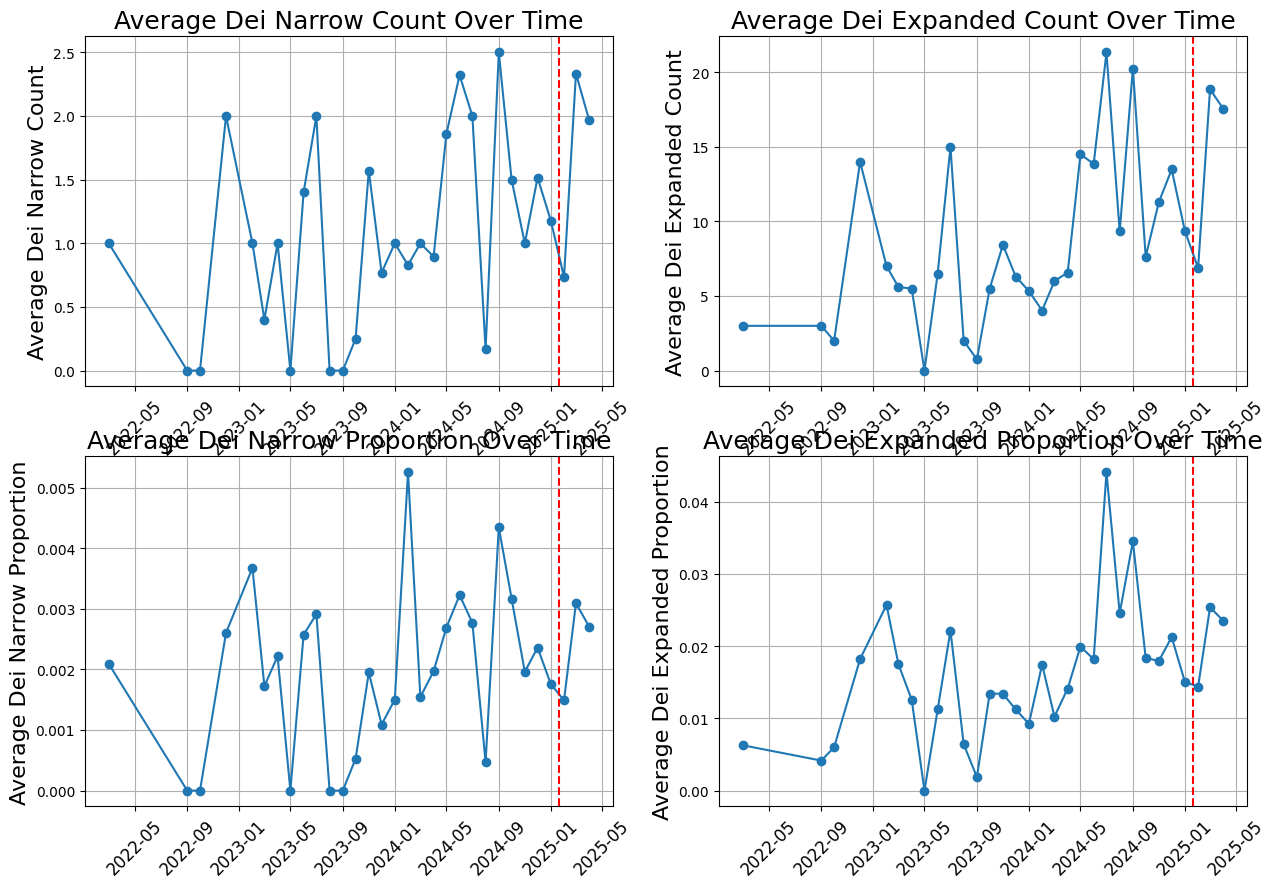

In [101]:
# plot distributions DEI metrics by date.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

eo_datetime = pd.to_datetime(EO_DATE.replace('_', '-'))

metrics = ['dei_narrow_count', 'dei_expanded_count', 'dei_narrow_proportion', 'dei_expanded_proportion']
for i, metric in enumerate(metrics):
    ax_i = ax[i // 2, i % 2]
    merged['date'] = pd.to_datetime(merged['job_posted_date'])
    monthly_means = merged.groupby(merged['date'].dt.to_period('M'))[metric].mean()
    monthly_means.index = monthly_means.index.to_timestamp()
    ax_i.plot(monthly_means.index, monthly_means.values, marker='o')
    ax_i.set_title(f'Average {metric.replace("_", " ").title()} Over Time', fontsize=18)
    # ax_i.set_xlabel('Date', fontsize=16)
    ax_i.tick_params(axis='x', labelrotation=45, labelsize=12)
    ax_i.set_ylabel(f'Average {metric.replace("_", " ").title()}', fontsize=16)
    ax_i.grid()
    # add eo date line
    ax_i.axvline(eo_datetime, color='red', linestyle='--', label='EO Date')


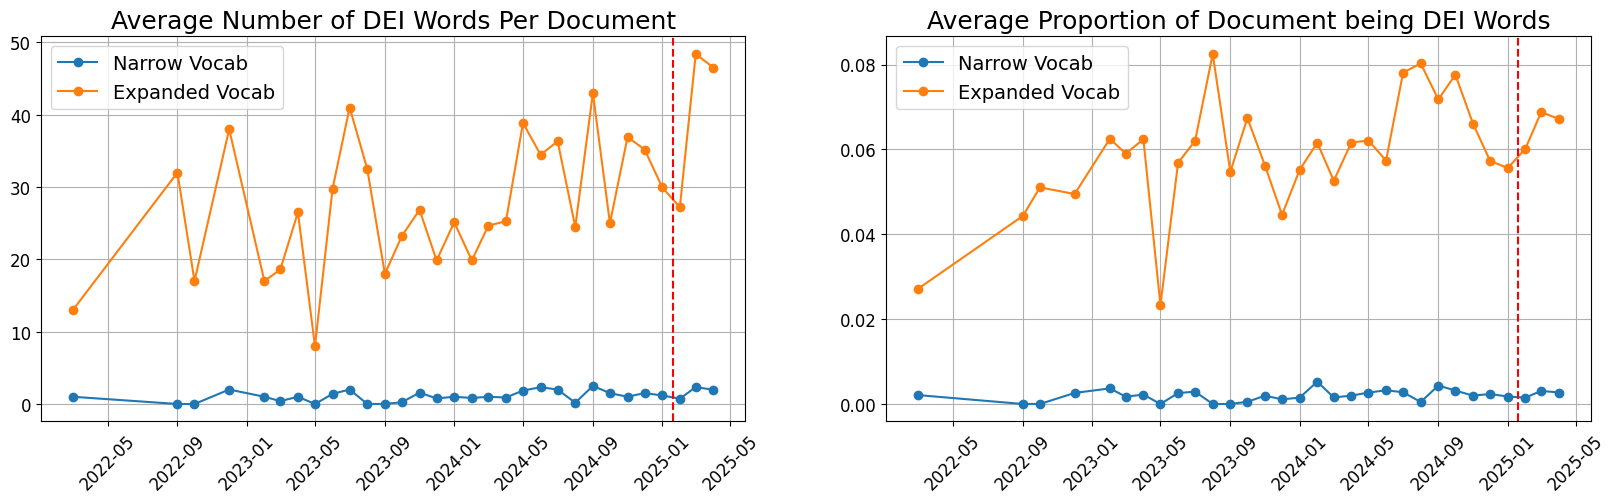

In [90]:
# plot the two proportions together and the two counts together
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
metrics_pairs = [
    ('dei_narrow_count', 'dei_expanded_count'),
    ('dei_narrow_proportion', 'dei_expanded_proportion')
]

for i, (metric1, metric2) in enumerate(metrics_pairs):
    ax_i = ax[i]
    merged['date'] = pd.to_datetime(merged['job_posted_date'])
    monthly_means_1 = merged.groupby(merged['date'].dt.to_period('M'))[metric1].mean()
    monthly_means_2 = merged.groupby(merged['date'].dt.to_period('M'))[metric2].mean()
    monthly_means_1.index = monthly_means_1.index.to_timestamp()
    monthly_means_2.index = monthly_means_2.index.to_timestamp()
    ax_i.plot(monthly_means_1.index, monthly_means_1.values, marker='o', label="Narrow Vocab" if 'narrow' in metric1 else "Expanded Vocab")
    ax_i.plot(monthly_means_2.index, monthly_means_2.values, marker='o', label="Narrow Vocab" if 'narrow' in metric2 else "Expanded Vocab")
    ax_i.set_title(f'Average {"Number of DEI Words Per Document" if "count" in metric1 else "Proportion of Document being DEI Words"}', fontsize=18)
    # ax_i.set_xlabel('Date')
    ax_i.tick_params(axis='x', labelrotation=45, labelsize=12)
    ax_i.tick_params(axis='y', labelsize=12)
    # ax_i.set_ylabel(f'Average {"# Occurrences" if "count" in metric1 else "Proportion of Words"}', fontsize=16)
    ax_i.grid()
    ax_i.legend(fontsize=14)
    # add eo date line
    ax_i.axvline(eo_datetime, color='red', linestyle='--', label='EO Date')
plt.show()